# Analysis of the HGCAL position scan from the DESY TB (March 2018)

### Imports
ROOT, etc

In [1]:
import ROOT as rt

Welcome to JupyROOT 6.12/06


### Tree (TChain) definition

In [41]:
tree = rt.TChain("rechitntupler/hits", "Hits"); 
tree2 = rt.TChain("trackimpactntupler/impactPoints", "Tracks");

tree.AddFriend(tree2, "tracks");

Add files based on file pattern

In [42]:
### V2 ntuples
#pattern = "scan3/ntuple_1*" ## Scan#3 from 1372 to 1440
#pattern = "scan2/ntuple_1*" ## Scan#2 1464 to 1537
pattern = "calo_scan/ntuple_1*" ## Scan after calo setup 1229 to 1339

tree.Add(pattern);
tree2.Add(pattern);

Use TProof to speed up processing (caution!)

In [43]:
#rt.TProof.Open('workers=4').SetLogLevel(0)
#tree.SetProof()

In [44]:
%%time
tree.GetEntries()

CPU times: user 235 ms, sys: 55.5 ms, total: 291 ms
Wall time: 425 ms


596901L

Style setup for tree

In [45]:
tree.SetMarkerStyle(7)

### Variable definition through aliases

In [46]:
## rechit variable shortcuts
tree.SetAlias("rechit_HG","rechit_energyHigh");
tree.SetAlias("rechit_LG","rechit_energyLow");
tree.SetAlias("rechit_id","rechit_channel + 64*rechit_skiroc");
tree.SetAlias("rechit_gainHLG","abs(rechit_energyHigh/rechit_energyLow - 10)");

## Construct global impact position from PI stage position and track impact extraplotation and convert from mm to cm
tree.SetAlias("impactY","-(PI_positionY-140 - impactY_HGCal_layer_1)/10.");
tree.SetAlias("impactX","-(PI_positionX-85  - impactX_HGCal_layer_1)/10.");

## Deltas
tree.SetAlias("deltaX","rechit_x - impactX");
tree.SetAlias("deltaY","rechit_y - impactY");
tree.SetAlias("deltaR","sqrt(deltaX * deltaX + deltaY * deltaY)");

Basic cuts / preselection

In [8]:
## ensure PI position was stored
basecuts = "PI_positionY > 0 " 
## select events with only 1 track
basecuts += "&& ntracks == 1 " 
## rechit selection: first layer, energy around MIP, HG/LG consistent with 10
basecuts += "&& rechit_layer == 1 && rechit_energy > 0.5 && rechit_energy < 5 && rechit_gainHLG < 5"
## noisy channels
basecuts += "& !(rechit_skiroc == 0 && rechit_channel == 44)" # 

#basecuts += "&& event < 100 ";

Create eventlist from basecuts and use it

In [9]:
tree.Draw(">> elist",basecuts);
elist = rt.gDirectory.Get('elist')
tree.SetEventList(elist)
tree2.SetEventList(elist)

In [10]:
tree.SetCacheSize(-1)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.

0

Create canvas (required in notebooks)

In [11]:
canv = rt.TCanvas("canv","c",800,600);

## Alignment

#### Plot global raw impact positions (pre alignment)

- the last run was at the home (center) position

CPU times: user 1.85 s, sys: 53.4 ms, total: 1.9 s
Wall time: 1.94 s


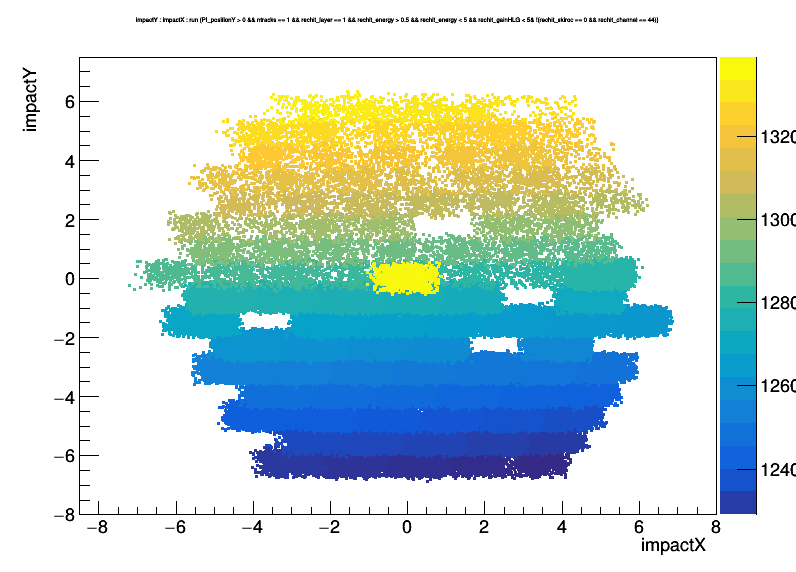

In [12]:
%%time
cuts = basecuts
canv.cd()
tree.Draw("impactY : impactX : run",cuts,"pcolz");
canv.Draw()

#### Plot rechit positions

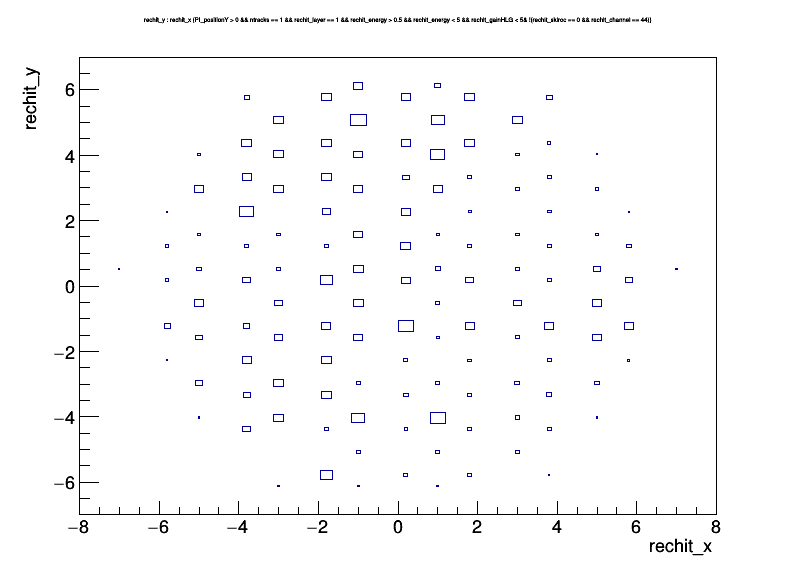

In [13]:
tree.Draw("rechit_y : rechit_x",cuts,"box");
canv.Draw()

Look at deltaX / deltaY and obtain mean offset (and fit gaussian)

 FCN=2682.71 FROM MIGRAD    STATUS=CONVERGED      78 CALLS          79 TOTAL
                     EDM=4.074e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.53011e+03   9.64698e+00   1.89548e-01   1.09611e-05
   2  Mean         3.34270e-01   1.86405e-03   4.71363e-05  -8.07432e-03
   3  Sigma        3.80474e-01   1.51039e-03   2.30578e-05   8.62575e-02


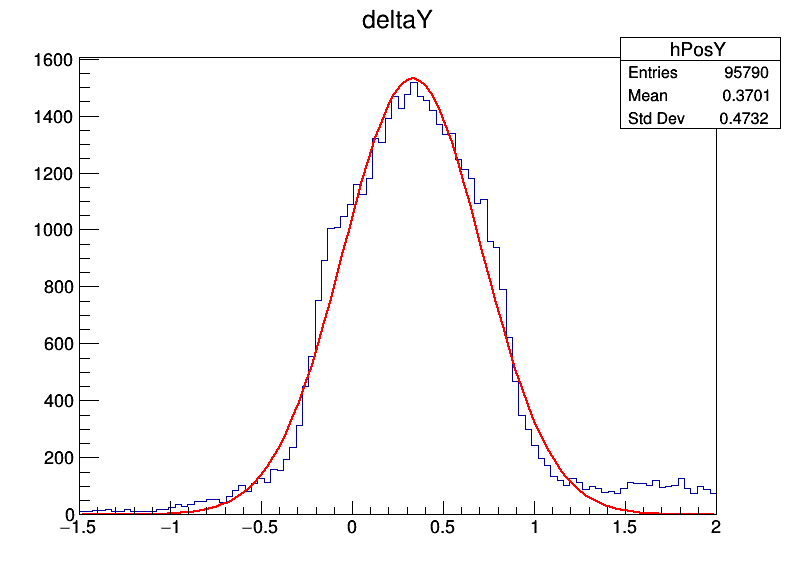

In [14]:
# require > 1 MIP to clean signal
cuts = basecuts + "&& rechit_energy > 1"

hPosY = rt.TH1F("hPosY","deltaY", 100,-1.5,2);
tree.Draw("deltaY >> hPosY ",cuts,"");
hPosY.Fit("gaus");

canv.Draw()

The deltaY distribution looks nice but is shifted by 0.37 / 0.33 cm (mean/fit)
- redefine impactY with the shift

In [15]:
tree.SetAlias("impactY","-(PI_positionY-140 - impactY_HGCal_layer_1)/10. + 0.34");

 FCN=4416.64 FROM MIGRAD    STATUS=CONVERGED      74 CALLS          75 TOTAL
                     EDM=2.43232e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     9.76125e+02   6.83437e+00   1.40378e-01   1.96687e-05
   2  Mean         2.13328e-01   3.70064e-03   1.13739e-04   4.02308e-02
   3  Sigma        7.42219e-01   4.57506e-03   4.16943e-05   1.43930e-01


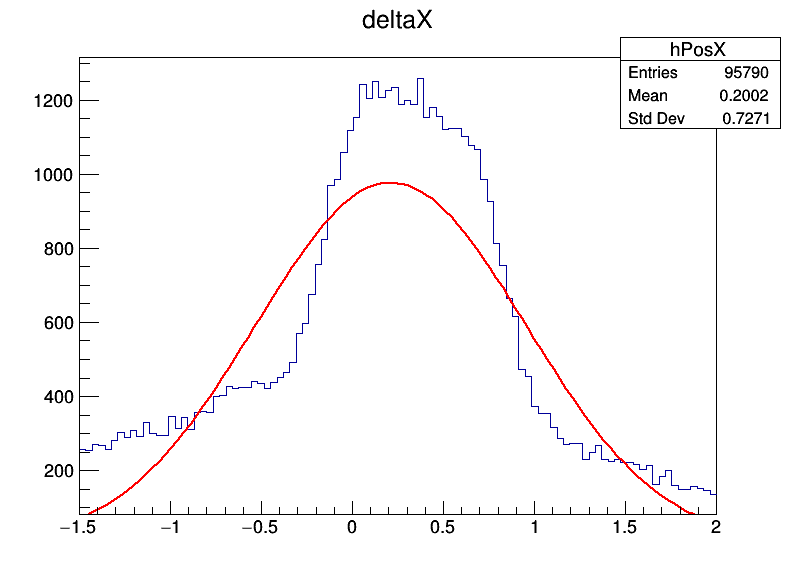

In [16]:
# require > 1 MIP to clean signal
cuts = basecuts + "&& rechit_energy > 1"

hPosX = rt.TH1F("hPosX","deltaX", 100,-1.5,2);
tree.Draw("deltaX >> hPosX ",cuts,"");
hPosX.Fit("gaus");

canv.Draw()

The deltaX distribution looks less nice / asymmetric and is also shifted by 0.2 / 0.21 cm (mean/fit)
- redefine impactY with the shift (guess of peak is ~0.3)

In [17]:
tree.SetAlias("impactX","-(PI_positionX-85  - impactX_HGCal_layer_1)/10. + 0.3");

### Control plots for alignment

In [18]:
## create canvas with 2 pads
canv_split = rt.TCanvas("canv_split","Split",1200,600);
canv_split.Divide(2);

#### DeltaX/deltaY vs the global channel id

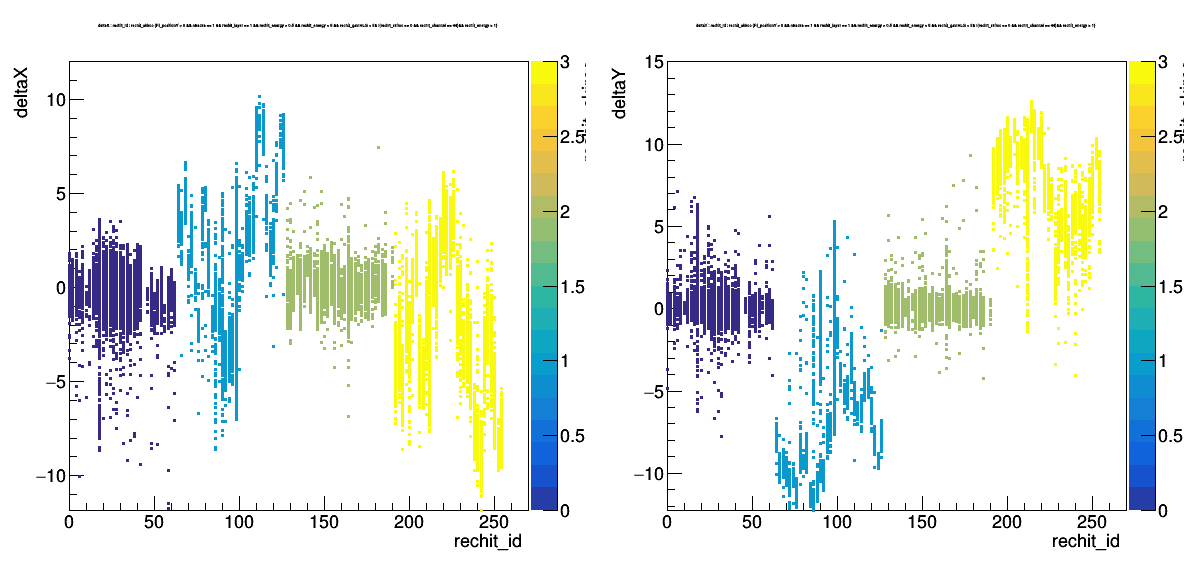

In [19]:
# require > 1 MIP to clean signal
cuts = basecuts + "&& rechit_energy > 1"

canv_split.cd(1)
tree.Draw("deltaX : rechit_id : rechit_skiroc",cuts,"pcolz");
canv_split.cd(2)
tree.Draw("deltaY : rechit_id : rechit_skiroc",cuts,"pcolz");

canv_split.Draw()

Chips 0 and 2 are flat, while chips 1 and 3 show symmetric misalignment patterns

#### Deltas vs run = scan position

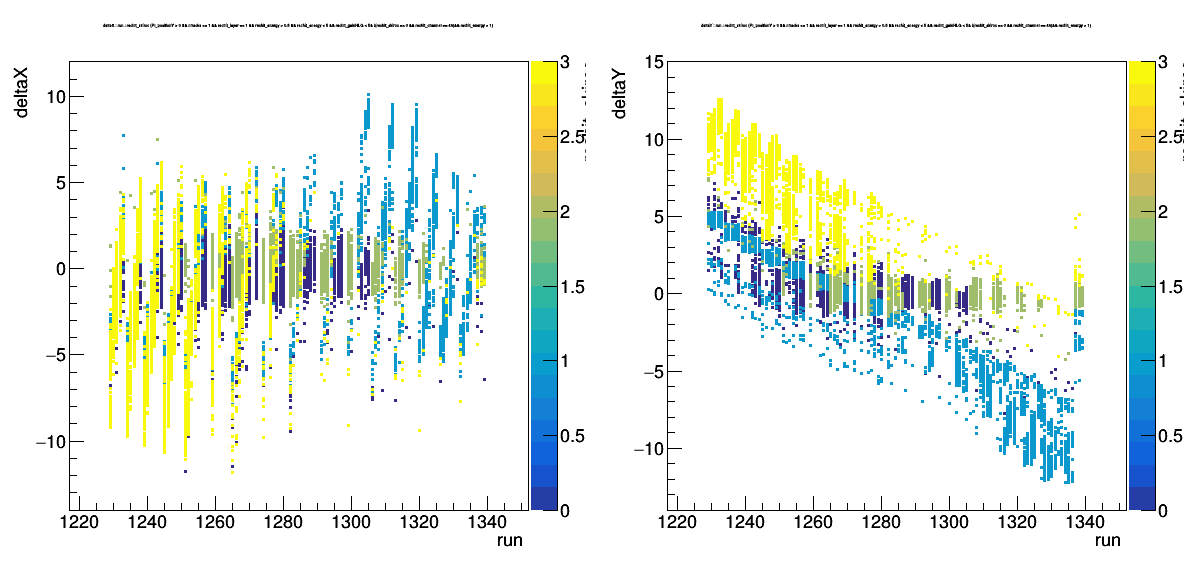

In [20]:
canv_split.cd(1)
tree.Draw("deltaX : run : rechit_skiroc",cuts,"pcolz");
canv_split.cd(2)
tree.Draw("deltaY : run : rechit_skiroc",cuts,"pcolz");

canv_split.Draw()

Deltas of chips 0 and 2 are stable wrt the run/stage position, while for chips 1 and 3 there is a trend pointing to misalignment of the rechit positions.

#### DeltaR vs channel ID and run number

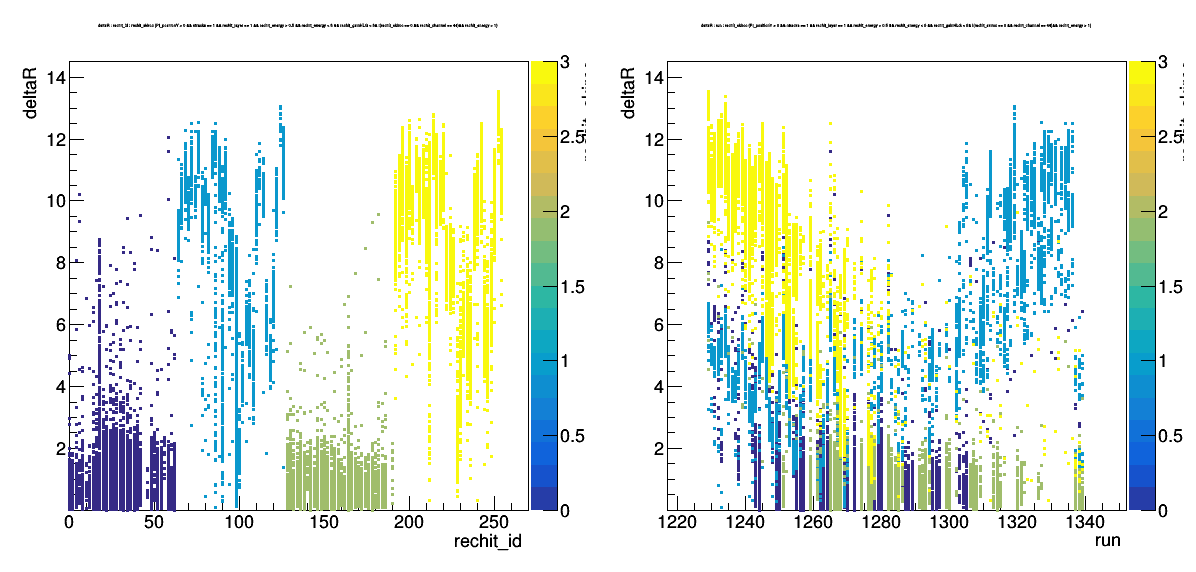

In [21]:
canv_split.cd(1); tree.Draw("deltaR : rechit_id : rechit_skiroc",cuts,"pcolz");
canv_split.cd(2); tree.Draw("deltaR : run : rechit_skiroc",cuts,"pcolz");
canv_split.Draw()

Again, for chips 0 and 2 the deltaR is low and flat, whereas for chips 1 and 3 there are symmetric offests

### Trying to fix chips 1&3 positions

Given the observed symmetric misalignment of chips 1 and 3, let's try to invert their positions:
`rechit_x/y = -rechit_x/y`

In [22]:
## Invert rechit positions for Chips 1 and 3 (use for bad mapping)
tree.SetAlias("rechit_corry","rechit_y * (-1+2*(rechit_skiroc%2 == 0))");
tree.SetAlias("rechit_corrx","rechit_x * (-1+2*(rechit_skiroc%2 == 0))");
## Update deltaX/Y definitions
tree.SetAlias("deltaX","rechit_corrx - impactX");
tree.SetAlias("deltaY","rechit_corry - impactY");

Repeat deltaX/Y vs channel id plots after position inversion for chips 1 and 3

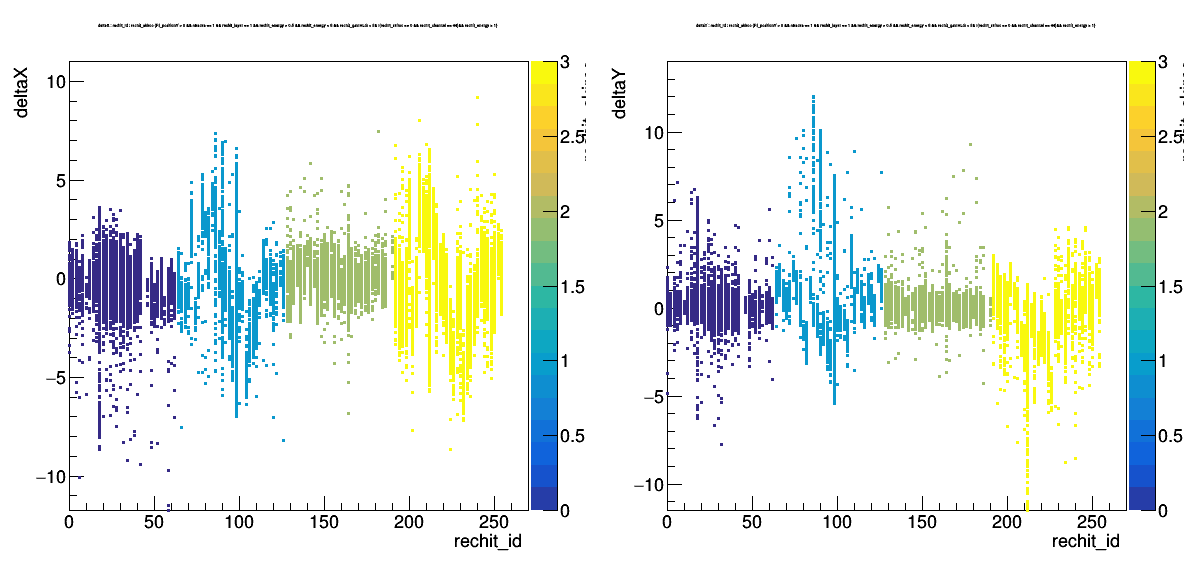

In [23]:
canv_split.cd(1); tree.Draw("deltaX : rechit_id : rechit_skiroc",cuts,"pcolz");
canv_split.cd(2); tree.Draw("deltaY : rechit_id : rechit_skiroc",cuts,"pcolz");
canv_split.Draw()

The large offset in the deltaX/Y is removed, with the symmetric offset shape still remaining

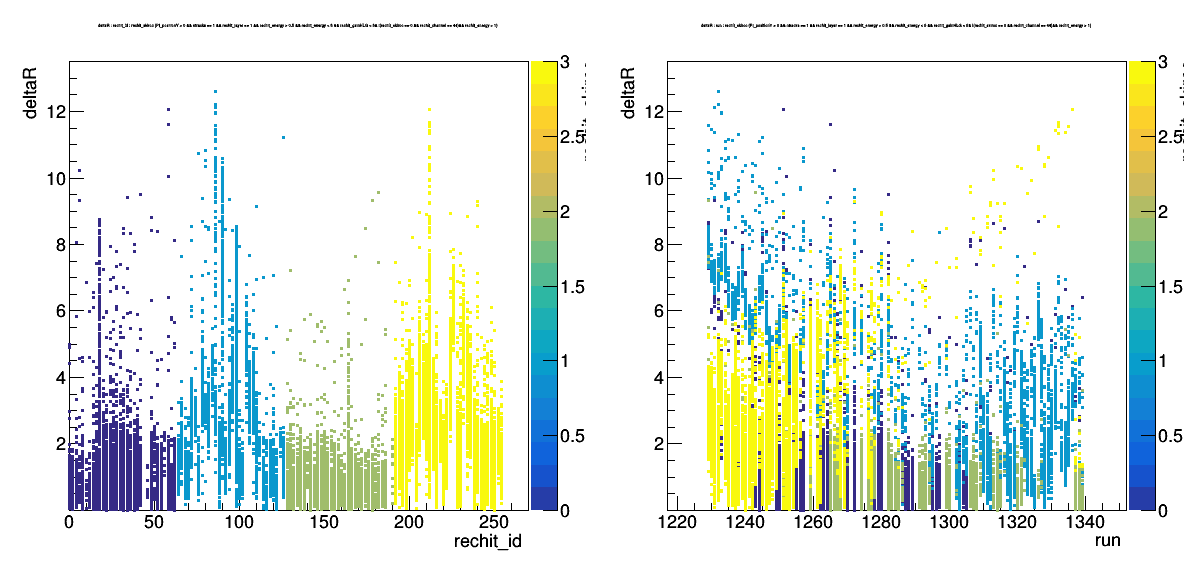

In [24]:
canv_split.cd(1); tree.Draw("deltaR : rechit_id : rechit_skiroc",cuts,"pcolz");
canv_split.cd(2); tree.Draw("deltaR : run : rechit_skiroc",cuts,"pcolz");
canv_split.Draw()

=> Residuals reduced, while still remaining for chips 1 and 3

### Check X and Y impact alignment

Use only the "good" even channels to do the alignment

 FCN=2242.2 FROM MIGRAD    STATUS=CONVERGED      67 CALLS          68 TOTAL
                     EDM=2.87852e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     9.85015e+02   7.21746e+00   1.16566e-01  -5.87435e-05
   2  Mean         2.59973e-03   2.42937e-03   5.53785e-05   1.74099e-01
   3  Sigma        4.64694e-01   2.47136e-03   2.68549e-05  -4.73356e-01
 FCN=1004.2 FROM MIGRAD    STATUS=CONVERGED      57 CALLS          58 TOTAL
                     EDM=8.03838e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.31696e+03   8.14631e+00   1.01143e-01   1.60316e-05
   2  Mean        -7.31822e-03   1.83274e-03   2.83721e-05  -2.43093e-02
   3  Sigma        3.69272e-01   1.

Warning in <TROOT::Append>: Replacing existing TH1: hPosX (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hPosY (Potential memory leak).


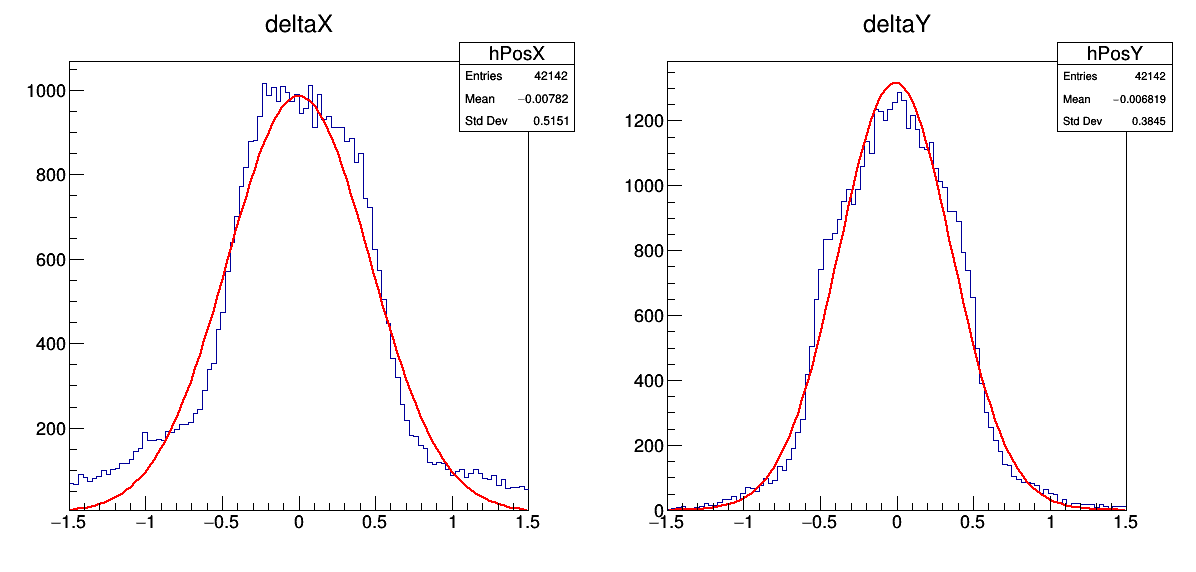

In [25]:
cuts = basecuts + "&& rechit_energy > 1 && rechit_skiroc%2 == 0"

## deltaX
canv_split.cd(1); 
hPosX = rt.TH1F("hPosX","deltaX", 100,-1.5,1.5); tree.Draw("deltaX >> hPosX ",cuts,"");
hPosX.Fit("gaus");

## deltaY
canv_split.cd(2); 
hPosY = rt.TH1F("hPosY","deltaY", 100,-1.5,1.5); tree.Draw("deltaY >> hPosY ",cuts,"");
hPosY.Fit("gaus");

canv_split.Draw()

Alignment looks good, so check the odd chip channels

Warning in <TROOT::Append>: Replacing existing TH1: hPosX (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hPosY (Potential memory leak).


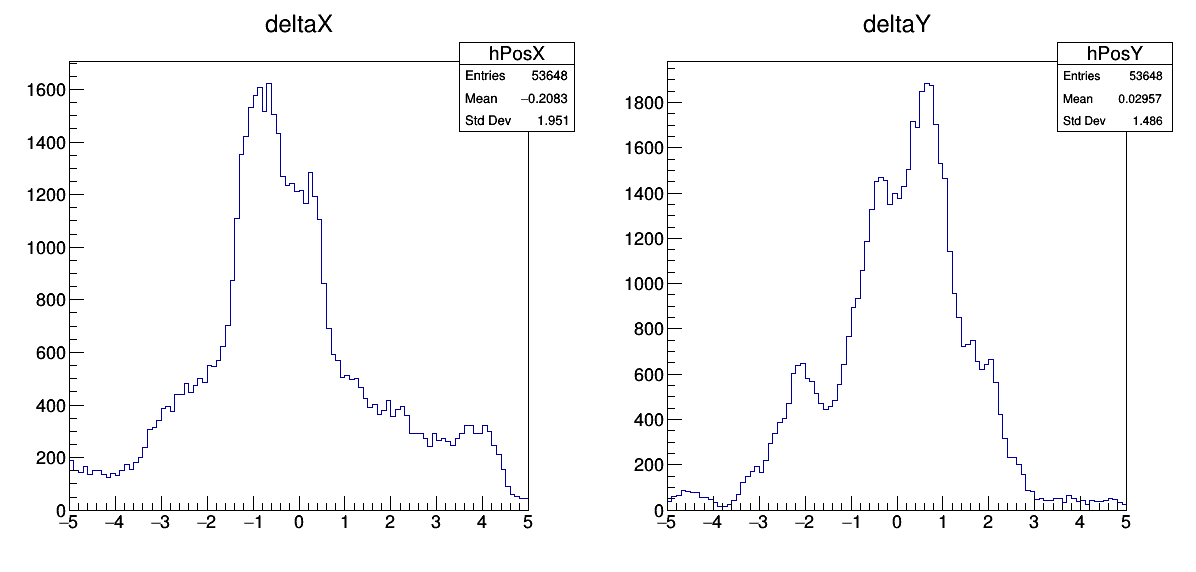

In [26]:
cuts = basecuts + "&& rechit_energy > 1 && rechit_skiroc%2 == 1"

## deltaX
canv_split.cd(1); 
hPosX = rt.TH1F("hPosX","deltaX", 100,-5,5); tree.Draw("deltaX >> hPosX ",cuts,"");
#hPosX.Fit("gaus");

## deltaY
canv_split.cd(2); 
hPosY = rt.TH1F("hPosY","deltaY", 100,-5,5); tree.Draw("deltaY >> hPosY ",cuts,"");
#hPosY.Fit("gaus");

canv_split.Draw()

`deltaX` is slightly negatively biased, and `deltaY` positively

#### Check deltaR

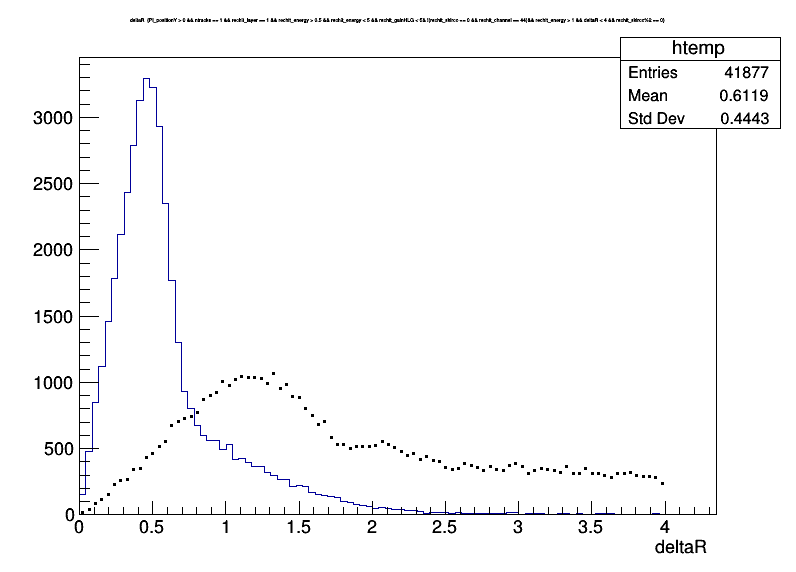

In [27]:
canv.cd() # return to single pad canvas
# plot only for "good" even chips
cuts = basecuts + "&& rechit_energy > 1 && deltaR < 4 && rechit_skiroc%2 == 0"; tree.Draw("deltaR ",cuts,"");
# overlay plot for even chips
cuts = basecuts + "&& rechit_energy > 1 && deltaR < 4 && rechit_skiroc%2 == 1"; tree.Draw("deltaR ",cuts,"p same");
canv.Draw()

`deltaR` still not centred at 0

#### Overall plot of deltaX/Y

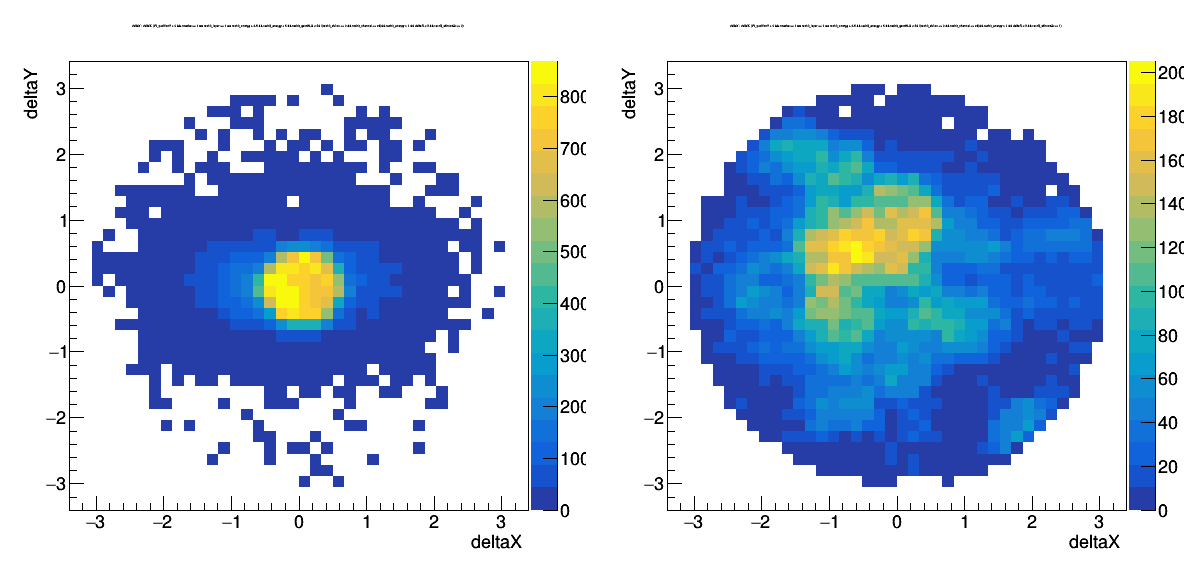

In [28]:
# plot only for "good" even chips
canv_split.cd(1); 
cuts = basecuts + "&& rechit_energy > 1 && deltaR < 3 && rechit_skiroc%2 == 0"
tree.Draw("deltaY : deltaX ",cuts,"colz");

# plot only for "bad" odd chips
canv_split.cd(2); 
cuts = basecuts + "&& rechit_energy > 1 && deltaR < 3 && rechit_skiroc%2 == 1"
tree.Draw("deltaY : deltaX ",cuts,"colz");

canv_split.Draw()

## Plots of energy

In [29]:
# return to basic cuts
cuts = basecuts

#### Plot rechit energy vs deltaR for each chip individually

In [30]:
# Divide new canvas into four pads and increase size
canv_split4 = rt.TCanvas("canv_split4","Split",2000,1200);
canv_split4.Divide(2,2);

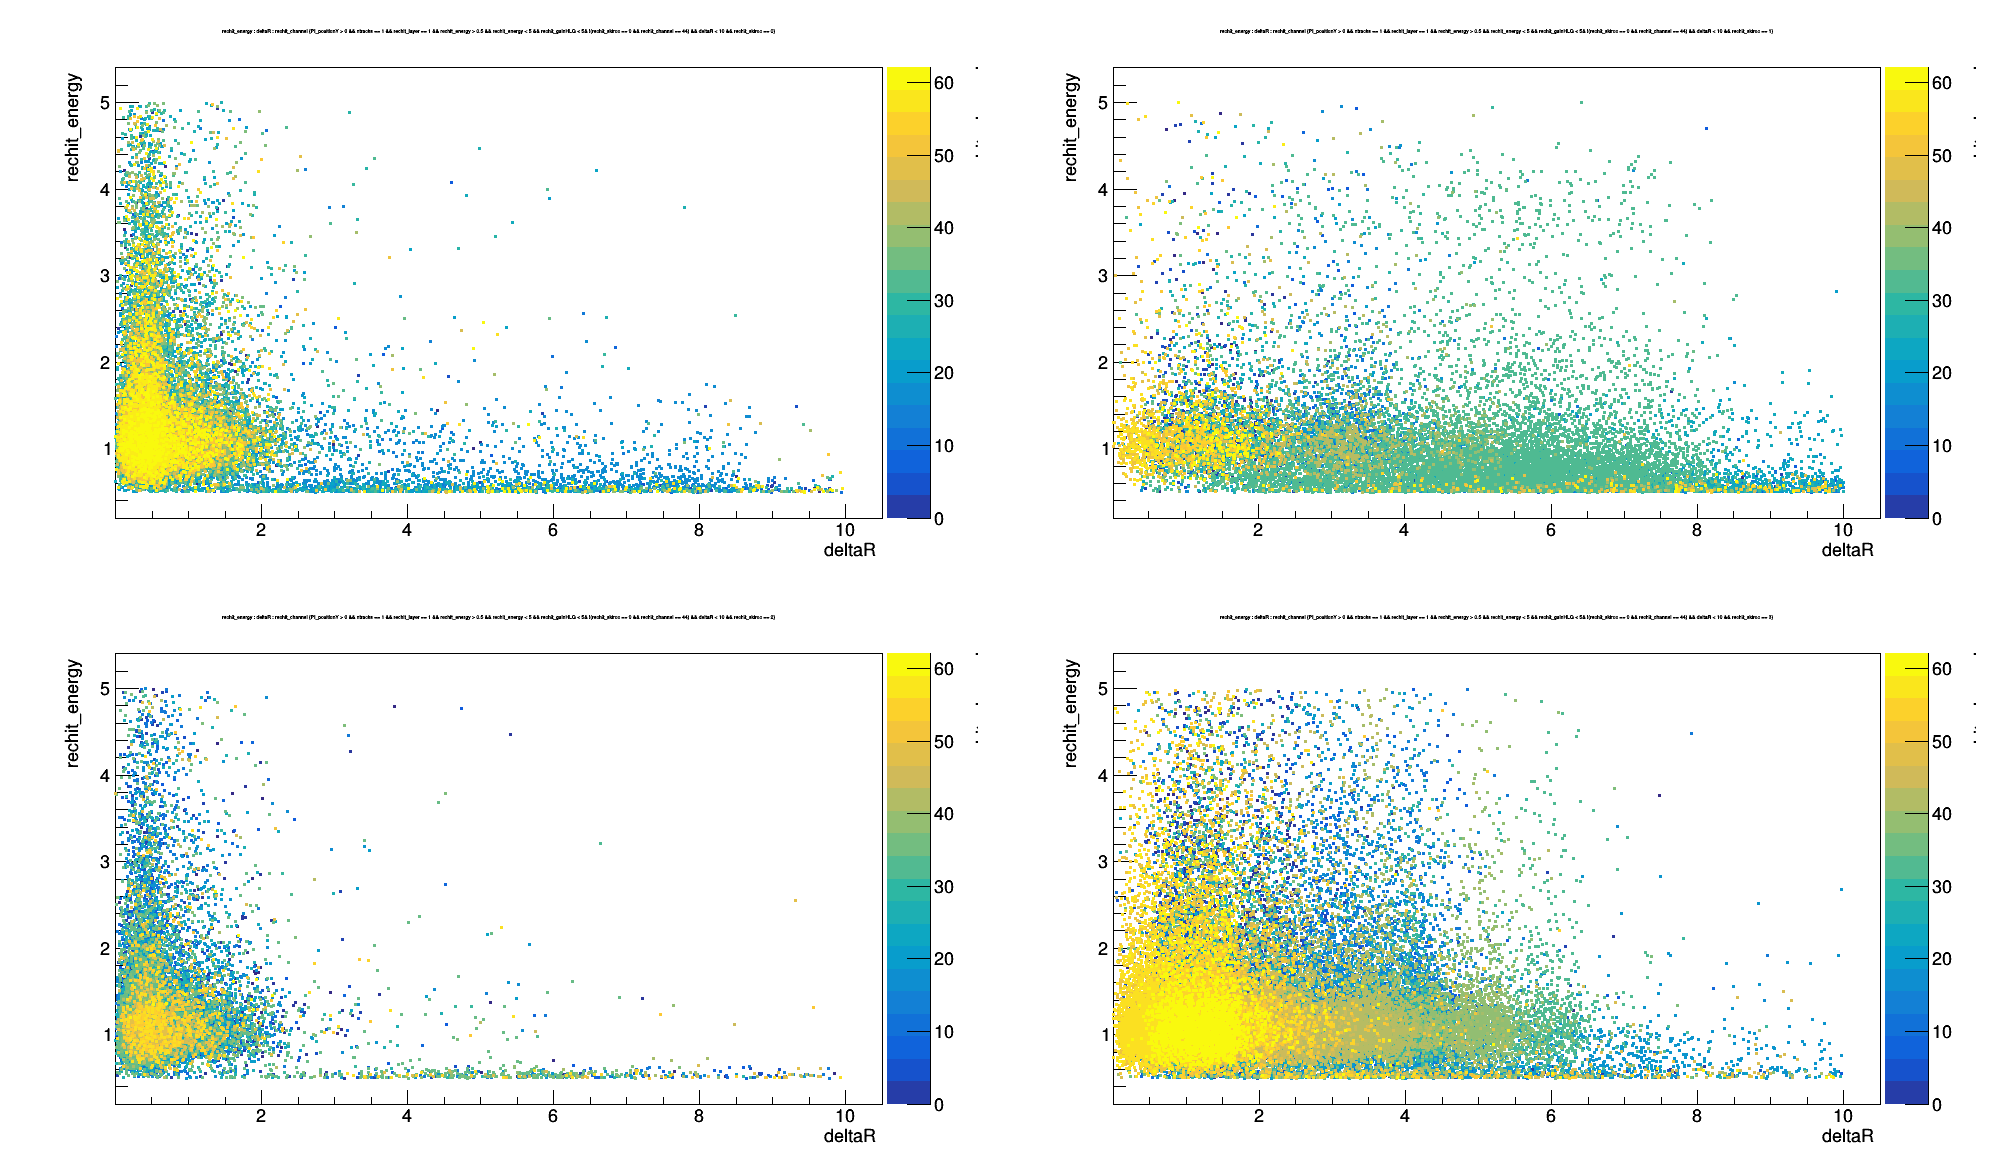

In [31]:
for chip in range(4):
    canv_split4.cd(chip+1);
 
    cuts = basecuts + " && deltaR < 10 && rechit_skiroc == %i" %chip;
    tree.Draw("rechit_energy : deltaR : rechit_channel",cuts,"pcolz");
    
canv_split4.Draw()

#### Plot rechit energy (HG) for different deltaR cuts

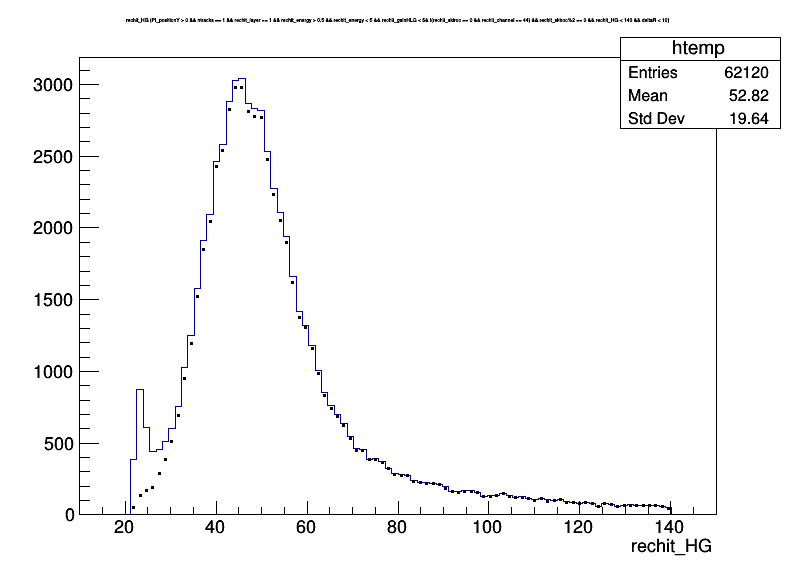

In [32]:
canv.cd()
cuts = basecuts + " && rechit_skiroc%2 == 0 && rechit_HG < 140 && deltaR < 10";
tree.Draw("rechit_HG",cuts,"");

cuts += " && deltaR < 2";
tree.Draw("rechit_HG",cuts,"p same");

canv.Draw()

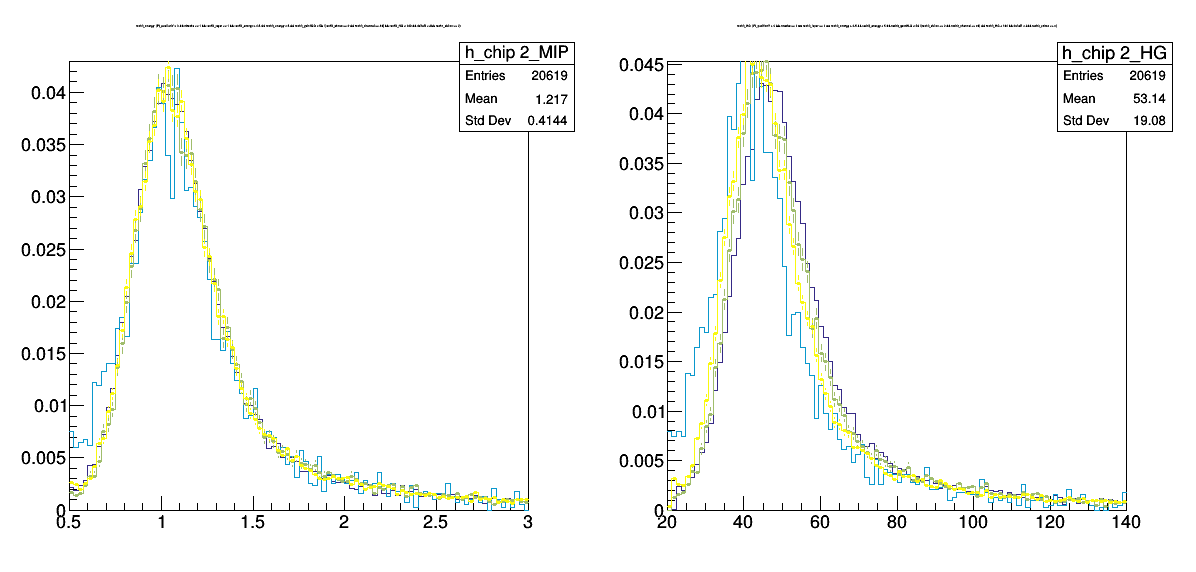

In [33]:
popt = "hist PLC PMC"
#canv.cd()
for chip in range(0,4,1):
    cuts = basecuts + " && rechit_HG < 140 && deltaR < 2";
    cuts += "&& rechit_skiroc == %i" %chip
    
    hname = "h_chip %i" % chip
    tree.Draw("rechit_energy >> " + hname +"_MIP(100,0.5,3)", cuts, "goff");
    
    hist = rt.gDirectory.Get(hname+"_MIP")
    canv_split.cd(1)
    hist.DrawNormalized(popt)
    
    tree.Draw("rechit_HG >> "     + hname +"_HG(100,20,140)", cuts, "goff");
    
    hist = rt.gDirectory.Get(hname+"_HG")
    canv_split.cd(2)
    hist.DrawNormalized(popt)
    
    popt += "same"
canv_split.Draw()

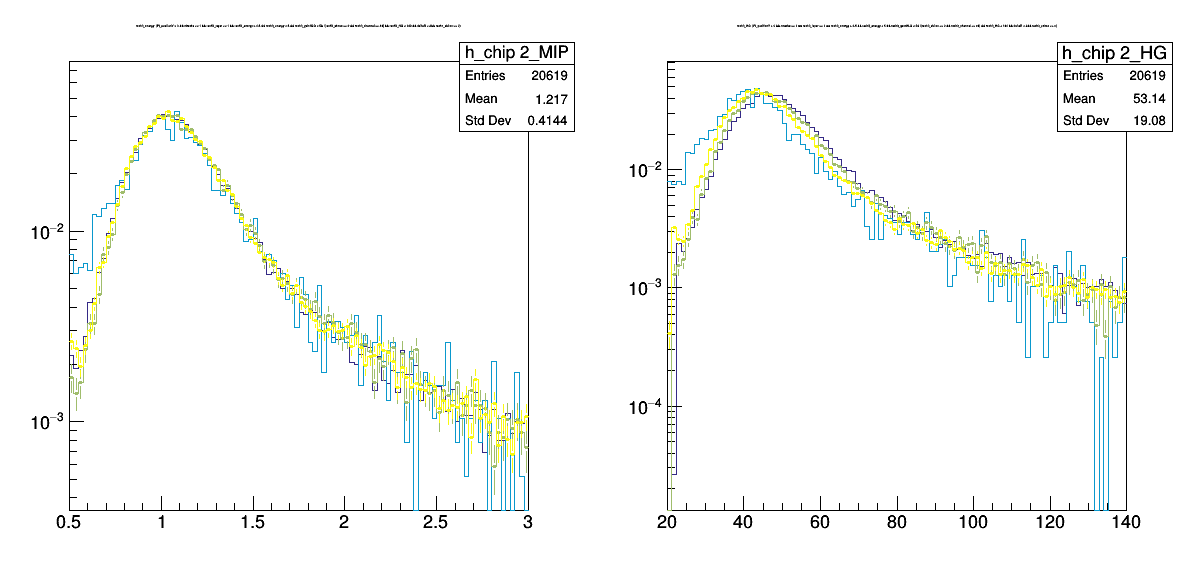

In [34]:
canv_split.cd(1).SetLogy()
canv_split.cd(2).SetLogy()

canv_split.Draw()

In [35]:
canv_split.cd(1).SetLogy(0)
canv_split.cd(2).SetLogy(0)

## MIP / MPV

Plot rechit energy vs channel id

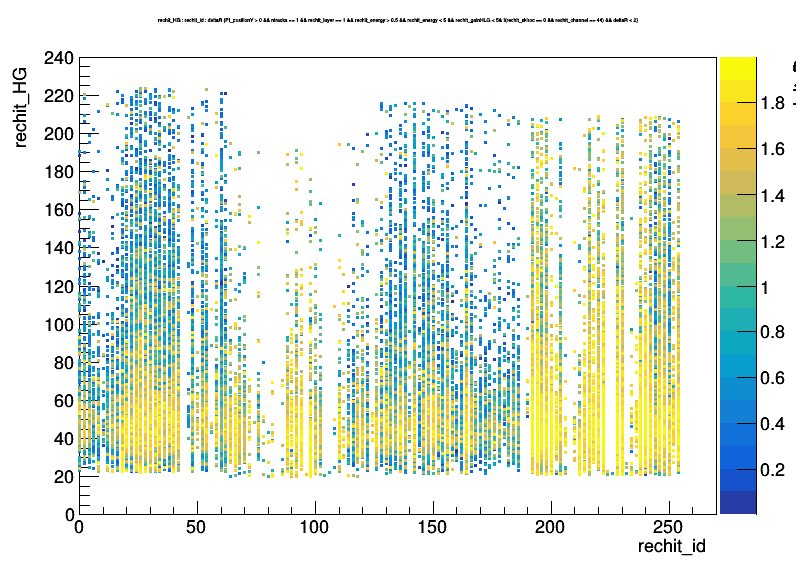

In [36]:
canv.cd()
cuts = basecuts + " && deltaR < 2";
tree.Draw("rechit_HG : rechit_id : deltaR", cuts,"pcolz");
canv.Draw()

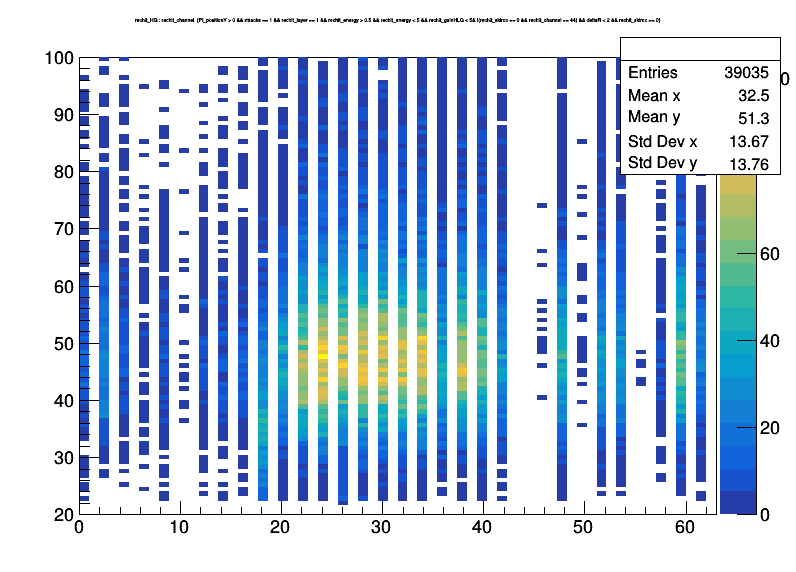

In [37]:
cuts = basecuts + " && deltaR < 2 && rechit_skiroc == 0";
tree.Draw("rechit_HG : rechit_channel >> (64,0,63,100,20,100)", cuts,"colz");
canv.Draw()

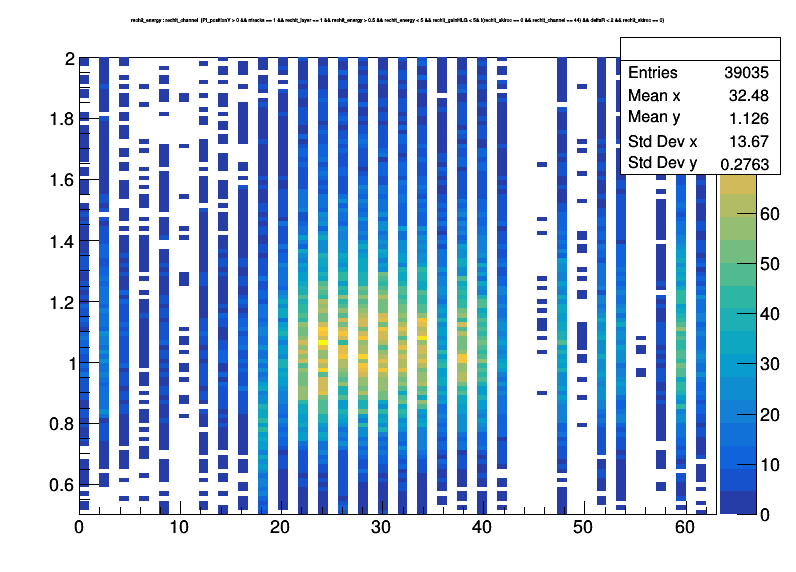

In [38]:
cuts = basecuts + " && deltaR < 2 && rechit_skiroc == 0";
tree.Draw("rechit_energy : rechit_channel >> (64,0,63,100,0.5,2)", cuts,"colz");
canv.Draw()

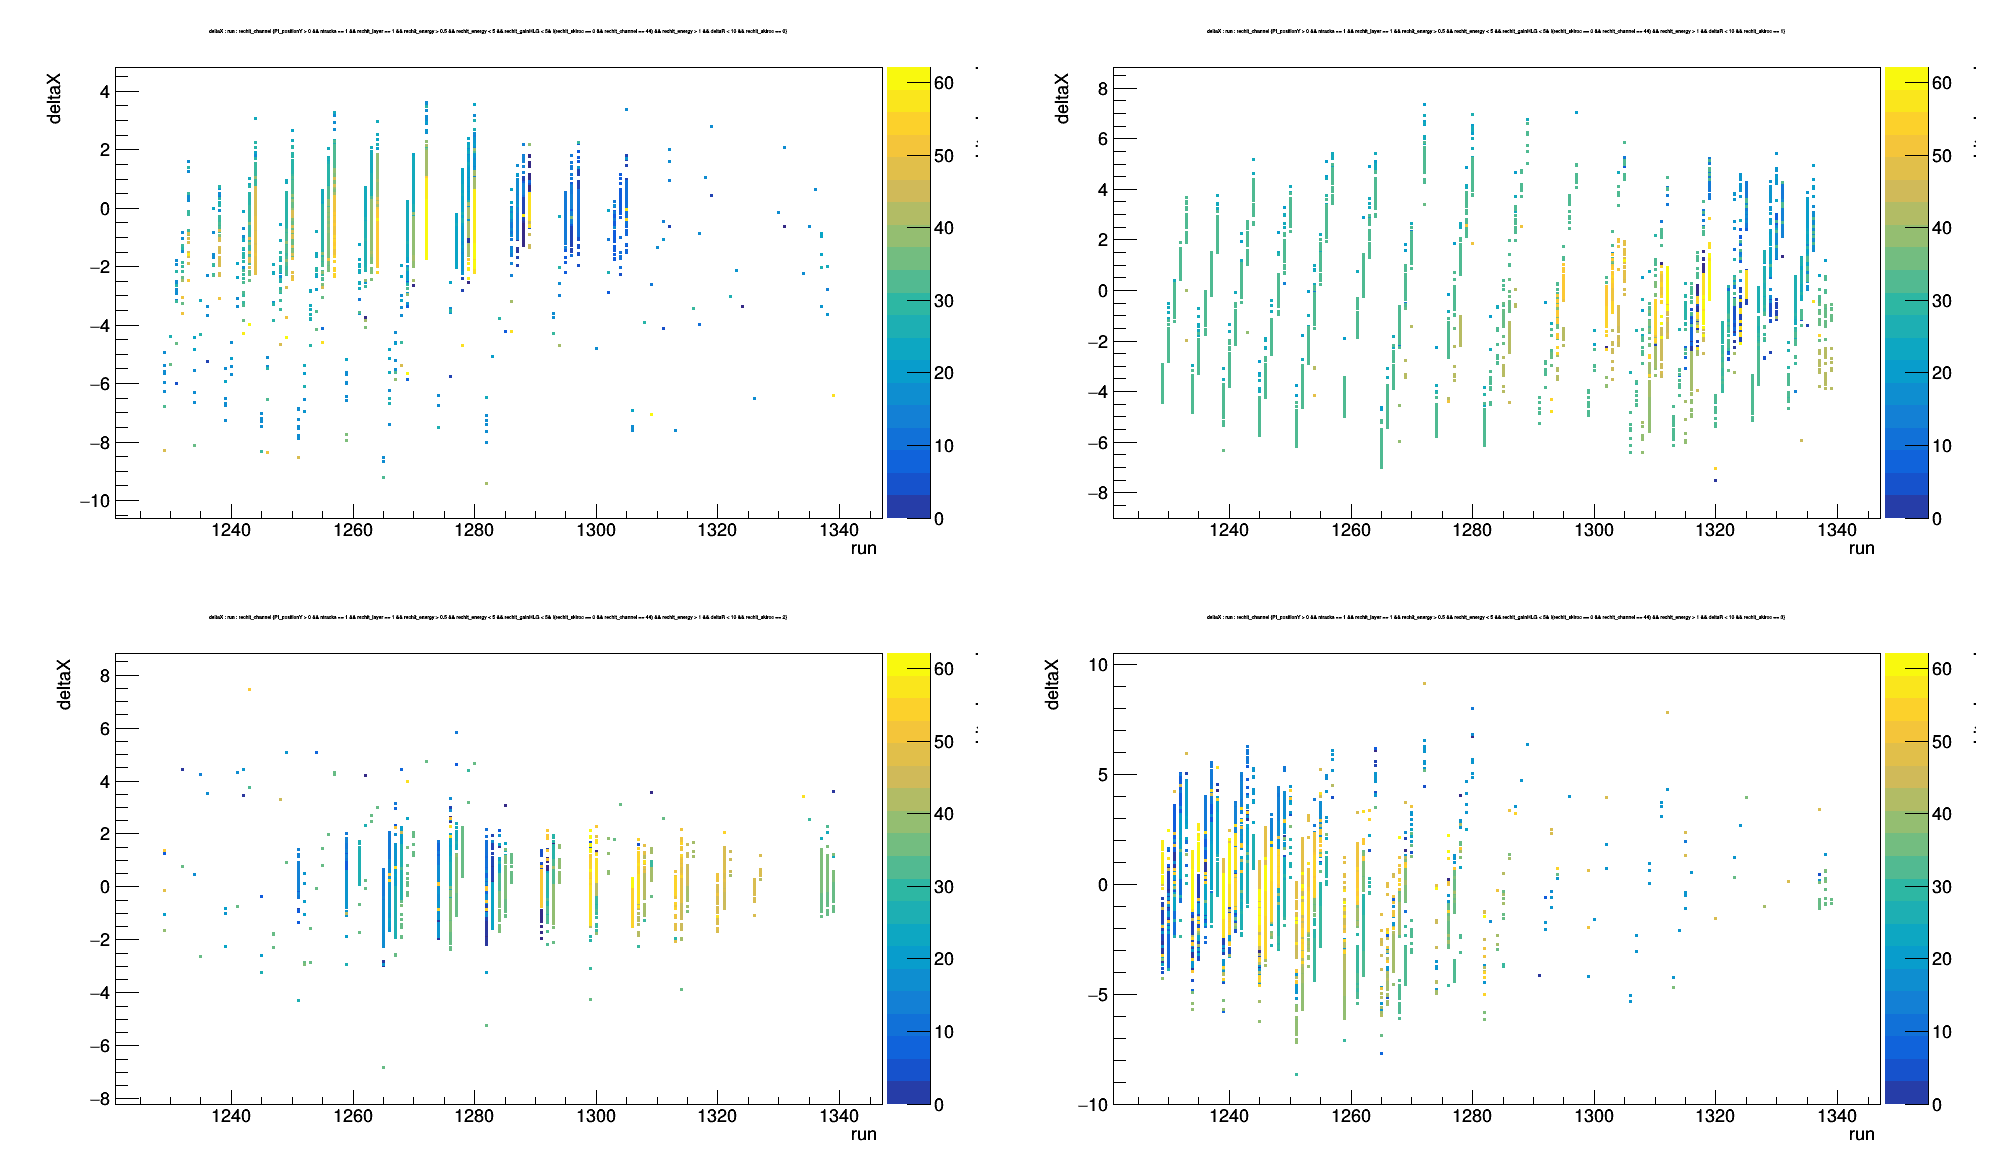

In [39]:
for chip in range(4):
    canv_split4.cd(chip+1);
 
    cuts = basecuts + " && rechit_energy > 1 && deltaR < 10 && rechit_skiroc == %i" %chip;
    tree.Draw("deltaX : run : rechit_channel",cuts,"pcolz");
    
canv_split4.Draw()

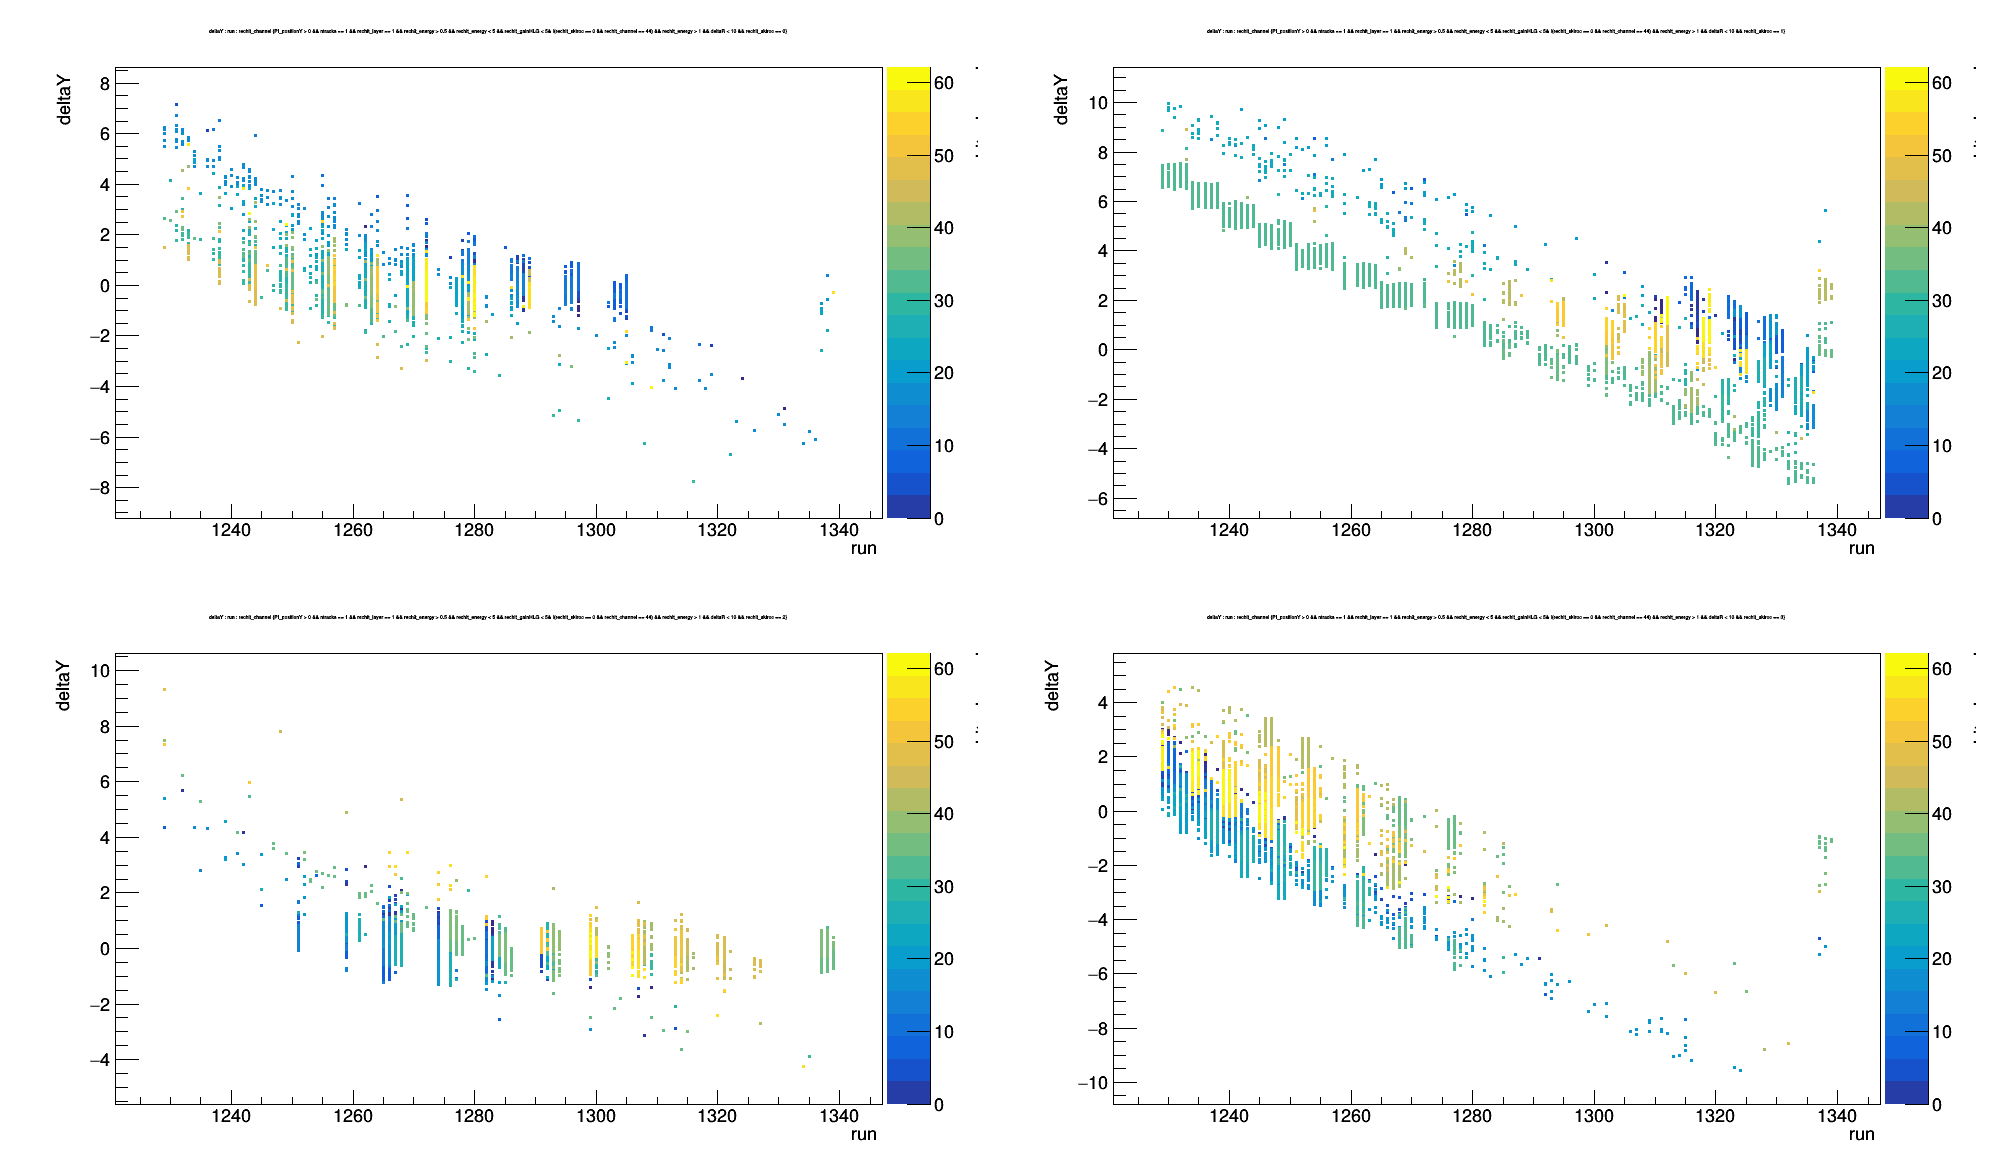

In [40]:
for chip in range(4):
    canv_split4.cd(chip+1);
 
    cuts = basecuts + " && rechit_energy > 1 && deltaR < 10 && rechit_skiroc == %i" %chip;
    tree.Draw("deltaY : run : rechit_channel",cuts,"pcolz");
    
canv_split4.Draw()